In [101]:
import gdal
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#fl = './data/swe_climatology_jepsen_krumholtz.tiff'
#ds = gdal.Open(fl,gdal.GA_ReadOnly)
#weights = np.array(ds.GetRasterBand(1).ReadAsArray())

weights = np.load('./data/scaled_jepsen_weights_60m.npy')

#fl = './data/LAI_krumholtz.tif'
fl = './data/landsat_LAI_Boulder_60m_crop.tiff'
ds = gdal.Open(fl,gdal.GA_ReadOnly)
lai = np.array(ds.GetRasterBand(1).ReadAsArray())
lai[lai<0] = np.NaN

#fl = './data/gridmet_60m_dem_krumholtz.tiff'
fl = '/RHESSys/Como/auxdata/gridmet_dem_60m_crop.tiff'
ds = gdal.Open(fl,gdal.GA_ReadOnly)
dem = np.array(ds.GetRasterBand(1).ReadAsArray())

In [3]:
n,m = lai.shape

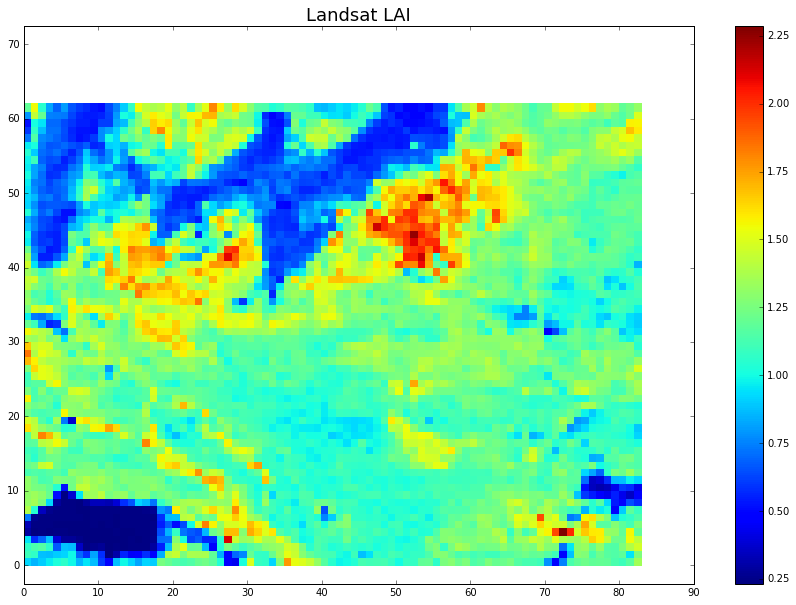

In [4]:
plt.figure(figsize=(15,10))
plt.pcolormesh(np.flipud(lai))
plt.colorbar()
plt.axis('equal')
plt.title('Landsat LAI',fontsize=18)

In [5]:
lai.shape

(62, 83)

In [6]:
dem.shape

(62, 83)

In [7]:
lai.shape = (n*m)
weights.shape = (n*m)
dem.shape = (n*m)

In [8]:
dat = pd.DataFrame()
dat['lai'] = lai
dat['elev'] = dem
dat['weight'] = weights

In [9]:
dat.sort_values('weight', ascending=True, inplace=True)

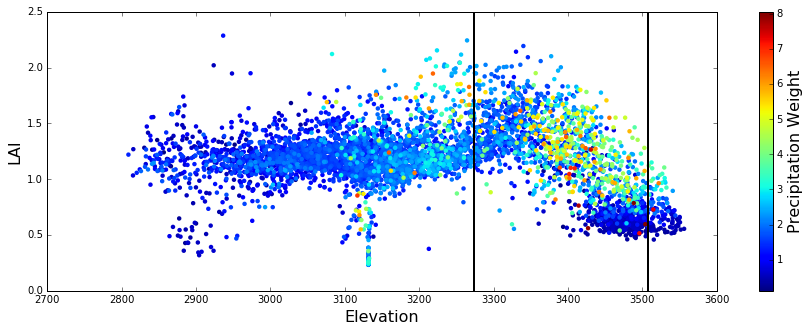

In [10]:
plt.figure(figsize=(15,5))
plt.scatter(dat.elev,dat.lai,s=20,c=dat.weight,edgecolors='None')
cb = plt.colorbar()
plt.xlabel('Elevation',fontsize=16)
plt.ylabel('LAI', fontsize=16)
plt.axvline(3507.3511,color='k',lw=2)
plt.axvline(3274.2654,color='k',lw=2)
cb.set_label('Precipitation Weight', fontsize = 16)

In [11]:
dat.sort_values('elev',ascending=True,inplace=True)

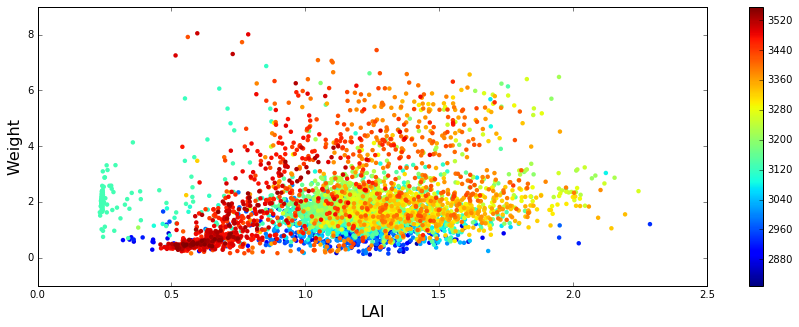

In [12]:
plt.figure(figsize=(15,5))
plt.scatter(dat.lai,dat.weight,s=20,c=dat.elev,edgecolors='None')
plt.colorbar()
plt.xlabel('LAI',fontsize=16)
plt.ylabel('Weight', fontsize=16)

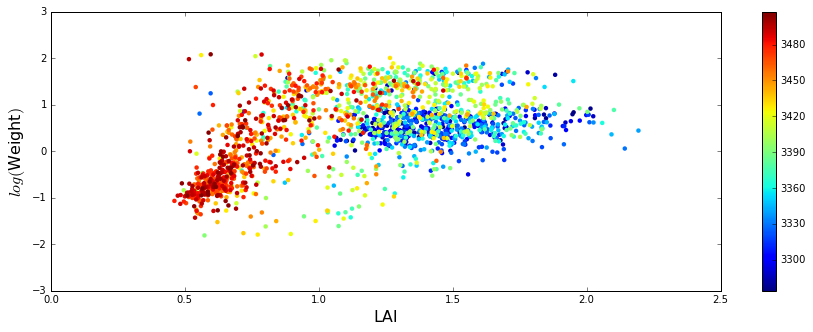

In [13]:
# & (dat.weight < 1.5)
tmp = dat.loc[(dat.elev >= 3274.2654) & (dat.elev<= 3507.3511)].copy()
tmp['trans_weight'] = np.log(tmp.weight)
plt.figure(figsize=(15,5))
plt.scatter(tmp.lai,tmp.trans_weight,s=20,c=tmp.elev,edgecolors='None')
plt.colorbar()
plt.xlabel('LAI',fontsize=16)
plt.ylabel('$log($Weight$)$', fontsize=16)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c001c90>]], dtype=object)

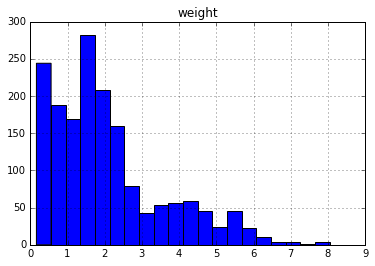

In [14]:
tmp.hist('weight',bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x101c33510>]], dtype=object)

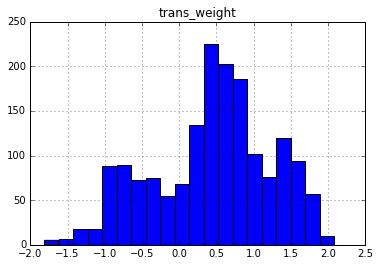

In [15]:
tmp.hist('trans_weight',bins=20)

In [16]:
mod = sm.formula.ols('trans_weight ~ lai + 1',tmp).fit()
print mod.rsquared
mod = sm.formula.ols('trans_weight ~ lai * elev + 1',tmp).fit()
mod.summary()
print mod.rsquared

0.287146129863
0.412005527732


In [81]:
# create regression surface to plot
n = 1000

xs = np.linspace(tmp.lai.min(),tmp.lai.max(),n)
ys = np.linspace(tmp.elev.min(),tmp.elev.max(),n)

xs,ys = np.meshgrid(xs,ys)

'log(P$_w$) = 42.96 - 42.46 * LAI + -0.013 * DEM + 0.013 * DEM * LAI'

def makesurf(lai,elev,n):
    return 42.96 - (42.46 * lai) + (-0.013 * elev) + (0.013 * (elev * lai))

zs = makesurf(xs,ys,n)

# compute vmin and vmax 

vals = [zs.min(),zs.max(),tmp.trans_weight.min(),tmp.trans_weight.max()]
val = np.max([np.abs(np.min(vals)),np.abs(np.max(vals))])
vmin = -1.*val
vmax = val

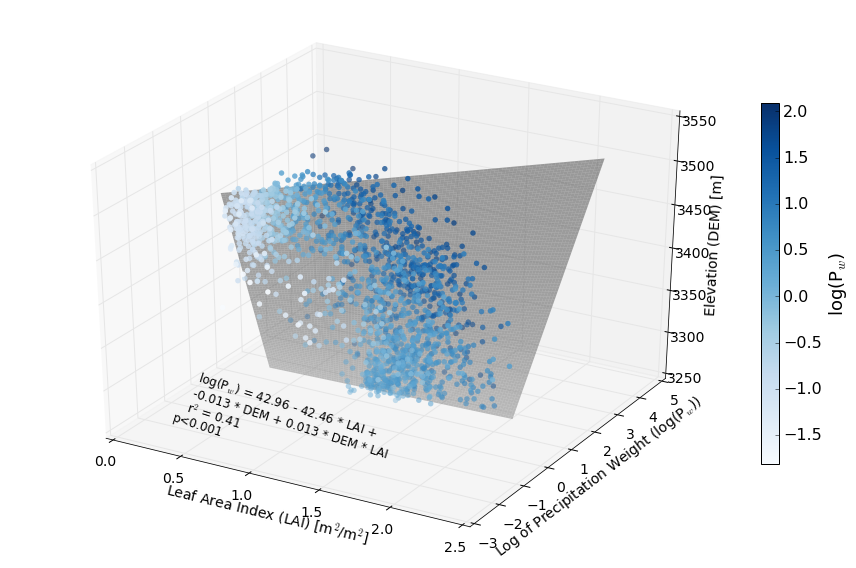

In [114]:
formula = 'log(P$_w$) = 42.96 - 42.46 * LAI +\n-0.013 * DEM + 0.013 * DEM * LAI'
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter3D(tmp.lai,tmp.trans_weight,zs=tmp.elev,c=tmp.trans_weight,s=30,edgecolor='None',cmap='Blues')
ax.plot_surface(xs, zs, ys,alpha=0.5,edgecolor='None',color='0.5')
ax.set_ylabel('Log of Precipitation Weight (log(P$_w$))', fontsize=14)
ax.set_xlabel('Leaf Area Index (LAI) [m$^2$/m$^2$]', fontsize=14)
ax.set_zlabel('Elevation (DEM) [m]', fontsize = 14)
ax.text(0.1,-0.75,3250,formula, fontsize=12, zdir='x')
ax.text(0.2,-1.5,3250,'r$^2$ = %.2f'%mod.rsquared,fontsize=12,zdir='x')
ax.text(0.2,-2,3250,'p<0.001', fontsize=12,zdir='x')
cb = plt.colorbar(scat,fraction=0.046, pad=0.01, shrink = 0.65)
cb.set_label('log(P$_w$)', fontsize=18)
cb.ax.tick_params(labelsize=16) 
[tick.label.set_fontsize(14) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(14) for tick in ax.yaxis.get_major_ticks()];
[tick.label.set_fontsize(14) for tick in ax.zaxis.get_major_ticks()];
plt.tight_layout()
plt.savefig('./figures/Pweight_lai_elev_perspective.pdf',bbox_inches='tight')
plt.savefig('./figures/Pweight_lai_elev_perspective.png',bbox_inches='tight',dpi=300)

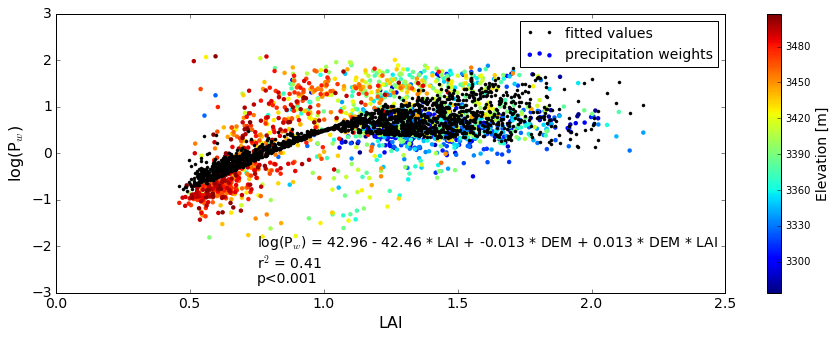

In [42]:
formula = 'log(P$_w$) = 42.96 - 42.46 * LAI + -0.013 * DEM + 0.013 * DEM * LAI'
plt.figure(figsize=(15,5))
plt.scatter(tmp.lai,tmp.trans_weight,s=20,c=tmp.elev,edgecolors='None',label='precipitation weights')
cb = plt.colorbar()
plt.xlabel('LAI',fontsize=16)
plt.ylabel('log(P$_w$)', fontsize=16)
plt.plot(tmp.lai,mod.fittedvalues,'.k',label='fitted values')
plt.legend(fontsize=14)
cb.set_label('Elevation [m]', fontsize=14)
ax = plt.gca()
[tick.label.set_fontsize(14) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(14) for tick in ax.yaxis.get_major_ticks()];

plt.text(0.75,-2,formula, fontsize=14)
plt.text(0.75,-2.49,'r$^2$ = %.2f'%mod.rsquared,fontsize=14)
plt.text(0.75,-2.77,'p<0.001', fontsize=14)
plt.savefig('./figures/landsat_lai_jepsen_peakSWE.png',dpi=300,bbox_inches='tight')

In [25]:
mod.model.formula

'trans_weight ~ lai * elev + 1'

In [ ]:
formula = 'log(P$_w$) = 42.96 - 42.46 * LAI + -0.013 * DEM + 0.013 * DEM * LAI'

In [37]:
mod.f_pvalue

3.3327279813009482e-195

In [21]:
mod.params

Intercept    42.961939
lai         -42.455669
elev         -0.012848
lai:elev      0.012846
dtype: float64

In [12]:
import scipy

In [13]:
curve = lambda t,a,b: a + b*np.log(t)
pars,out = scipy.optimize.curve_fit(curve,x,y)
xx = np.linspace(x.min(),x.max(),1000)
yy = pars[0] + pars[1]*np.log(xx)

In [14]:
# compute r2: https://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy
yhat = pars[0] + pars[1]*np.log(x)
ybar = np.sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)
sstot = np.sum((y-ybar)**2)
r2 = 1- (ssreg/sstot)

# compute F statistic: http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
dfm = len(pars)-1
msm = ssreg/dfm
mse = sstot/dfm

f = msm/mse

# convert F to p-value: https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python
df1 = len(x)
df2 = len(y) - 1

pval = scipy.stats.f.cdf(f,df1,df2)

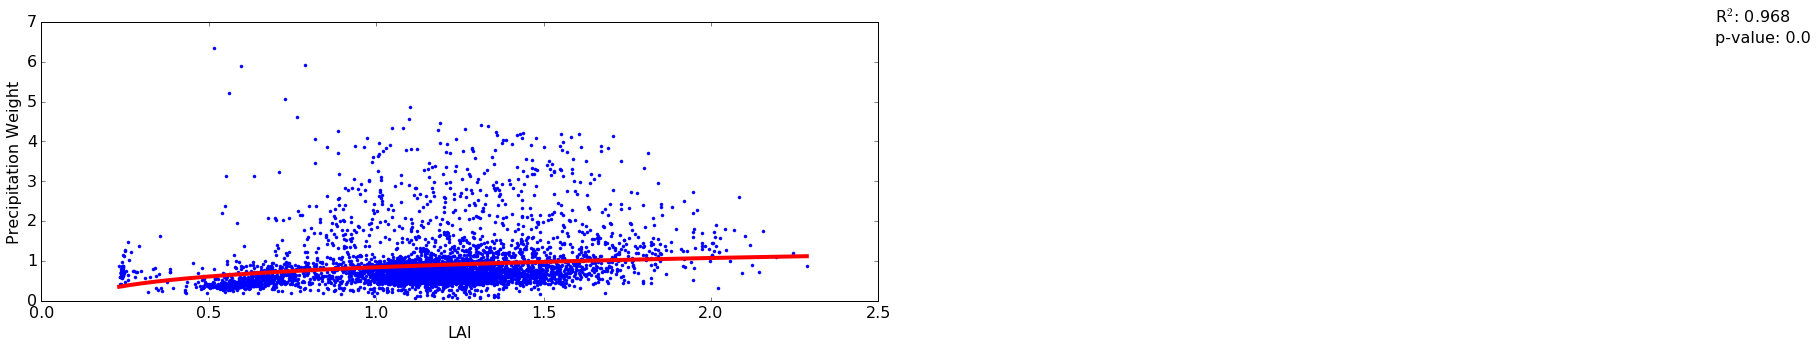

In [15]:
plt.figure(figsize=(15,5))
plt.plot(x,y,'.')
plt.plot(xx,yy,'-r',lw = 4)
plt.xlabel('LAI',fontsize=16)
plt.ylabel('Precipitation Weight', fontsize=16)
plt.text(5,7.,'R$^2$: %s'%(round(r2,3)), fontsize=16)
plt.text(5,6.5,'p-value: %s'%(round(pval,3)), fontsize=16)
ax = plt.gca()
[tick.label.set_fontsize(16) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(16) for tick in ax.yaxis.get_major_ticks()];
plt.savefig('./figures/precipitation_weight_lai.png',dpi=300,bbox_inches='tight')

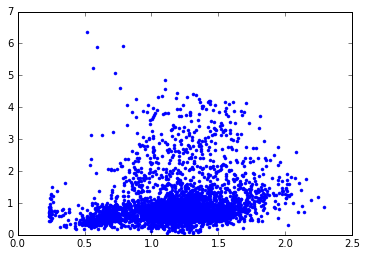

In [18]:
plt.plot(x,y,'.')

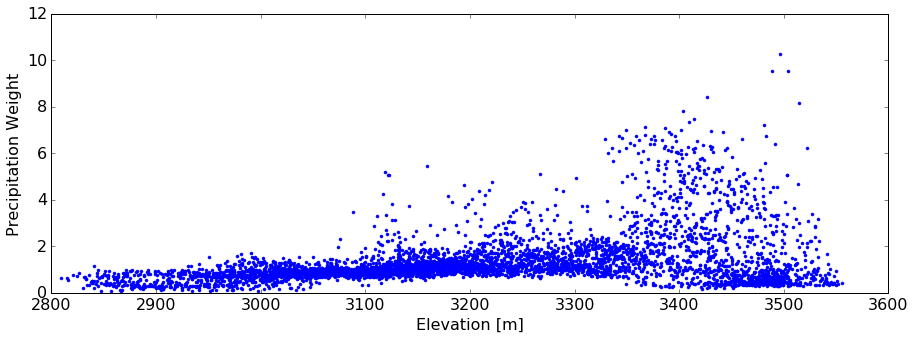

In [255]:
plt.figure(figsize=(15,5))
plt.plot(dem,weights,'.')
plt.xlabel('Elevation [m]', fontsize = 16)
plt.ylabel('Precipitation Weight', fontsize = 16)
ax = plt.gca()
[tick.label.set_fontsize(16) for tick in ax.xaxis.get_major_ticks()];
[tick.label.set_fontsize(16) for tick in ax.yaxis.get_major_ticks()];
plt.savefig('./figures/precipitatioin_elevation.png',dpi=300,bbox_inches='tight')

In [229]:
# above ~3350 m the relationship between elevation and weight breaks down.
w = weights[dem<=3350]
e = dem[dem<=3350]
l = lai[dem<=3350]

In [230]:
e2 = sm.add_constant(e)
mod = sm.OLS(w,e2).fit()

x = np.linspace(e.min(),e.max(),100)
y = x*mod.params[1]+ mod.params[0] 

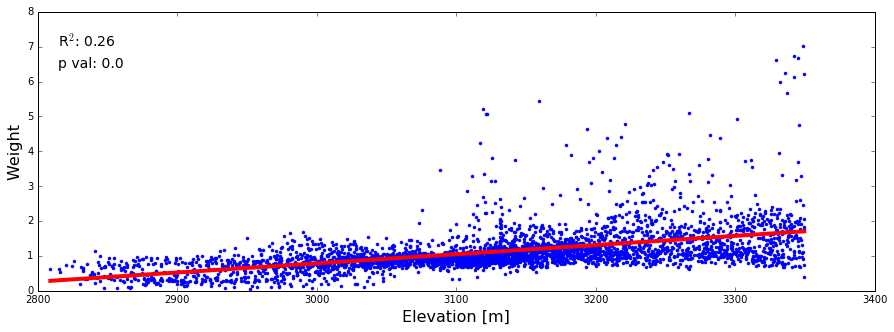

In [237]:
plt.figure(figsize=(15,5))
plt.plot(e,w,'.')
plt.plot(x,y,'-r',lw=4)
plt.xlabel('Elevation [m]', fontsize = 16)
plt.ylabel('Weight', fontsize = 16)
plt.text(2815,7,'R$^2$: %s'%(mod.rsquared.round(2)), fontsize = 14)
plt.text(2815,6.4,'p val: %s'%(mod.f_pvalue.round(3)), fontsize = 14)

In [226]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     1344.
Date:                Wed, 13 Sep 2017   Prob (F-statistic):          1.71e-252
Time:                        12:17:25   Log-Likelihood:                -2936.5
No. Observations:                3826   AIC:                             5877.
Df Residuals:                    3824   BIC:                             5890.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -7.0910      0.224    -31.632      0.000        -7.530    -6.651
x1             0.0026   7.16e-05     36.667      0.000         0.002     0.003
==============================================================================
Omnibus:                     3211.592   Durbin-Watson:                   0.550
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111763.114
Skew:                           3.843   Prob(JB):                         0.00
Kurtosis:                      28.338   Cond. No.                     8.32e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""